In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy

from generator import Generator
from inverse import fit_SLSQP, fit_matrix

%matplotlib inline  

def plot():
    plt.grid()
    plt.legend()
    plt.show()

### Генерируем изотерму, решаем для нее обратную задачу

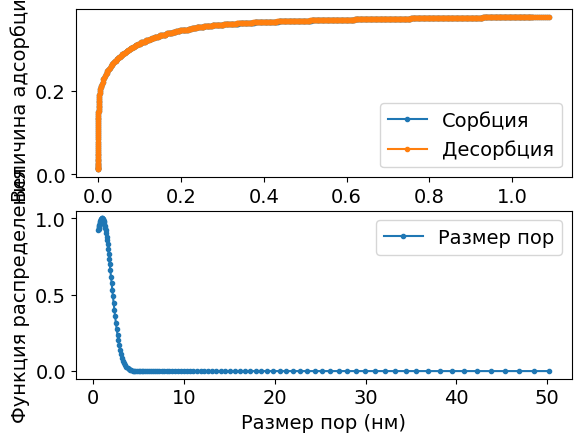

In [5]:
gen = Generator(path_s="data/initial kernels/Kernel_Carbon_Adsorption.npy",
                        path_d="data/initial kernels/Kernel_Carbon_Desorption.npy",
                        path_p_d="data/initial kernels/Pressure_Carbon.npy",
                        path_p_s="data/initial kernels/Pressure_Carbon.npy",
                        path_a="data/initial kernels/Size_Kernel_Carbon_Adsorption.npy"
                )
gen.generate_pore_distribution(sigma1=1, sigma2=2, d0_1=1, d0_2=20, a=1)
gen.calculate_calculate_isotherms_right()
gen.interp_desorption()
_ = gen.plot_isotherm()

In [6]:
kernel_carbon = np.load("data/initial kernels/Kernel_Carbon_Adsorption.npy")
pore_widths = np.load("data/initial kernels/Size_Kernel_Carbon_Adsorption.npy")

In [7]:
fit1 = fit_SLSQP(adsorption=gen.n_s, kernel=kernel_carbon, a_array=pore_widths)
fit2 = fit_matrix(adsorption=gen.n_s, kernel=kernel_carbon.T)

C:\Users\ivano\PycharmProjects\isotherm\inverse.py:27: RuntimeWarning: divide by zero encountered in log
  adsorption)).sum(axis=0) + alpha * np.sum(w * np.log(w)) / len(pore_dist) + beta * np.sum(
C:\Users\ivano\PycharmProjects\isotherm\inverse.py:27: RuntimeWarning: invalid value encountered in multiply
  adsorption)).sum(axis=0) + alpha * np.sum(w * np.log(w)) / len(pore_dist) + beta * np.sum(


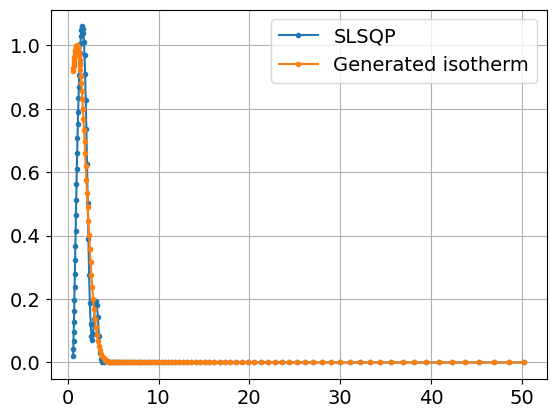

In [8]:
plt.plot(pore_widths, fit1.x, marker=".", label="SLSQP")
#plt.plot(pore_widths, fit2[0], marker=".", label="Matrix")
plt.plot(pore_widths, gen.pore_distribution, marker=".", label="Generated isotherm")
plot()

### Добавляем случайного шума к сгенерированной изотерме

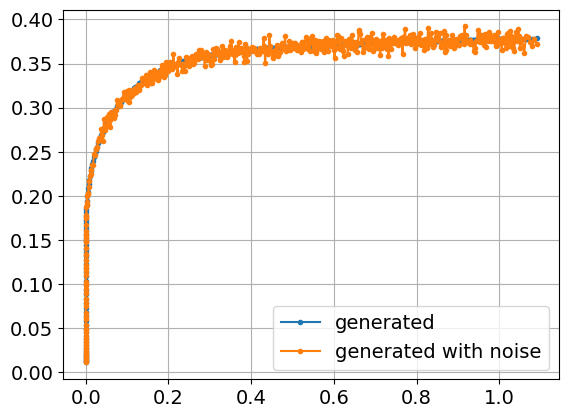

In [9]:
n_s_with_noise = gen.n_s * np.random.normal(loc=1, scale=0.015, size=len(gen.n_s))
plt.plot(gen.pressures_s, gen.n_s, marker=".", label="generated")
plt.plot(gen.pressures_s, n_s_with_noise, marker=".", label="generated with noise")
plot()

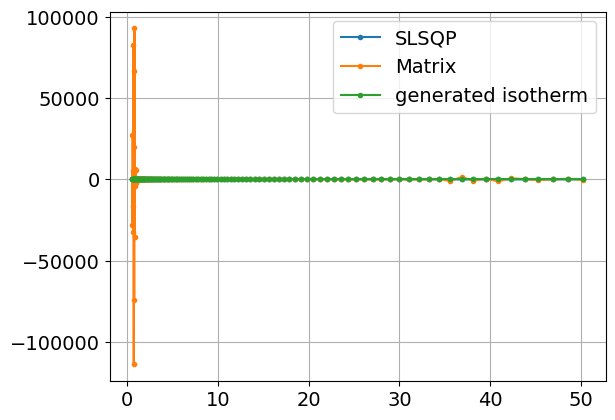

In [10]:
# решаем задачу с шумом
fit1_noise = fit_SLSQP(adsorption=n_s_with_noise, kernel=kernel_carbon, a_array=pore_widths)
fit2_noise = fit_matrix(adsorption=n_s_with_noise, kernel=kernel_carbon.T, rcond=0)
plt.plot(pore_widths, fit1_noise.x, marker=".", label="SLSQP")
plt.plot(pore_widths, fit2_noise[0], marker=".", label="Matrix")
plt.plot(pore_widths, gen.pore_distribution, marker=".", label="generated isotherm")
plot()

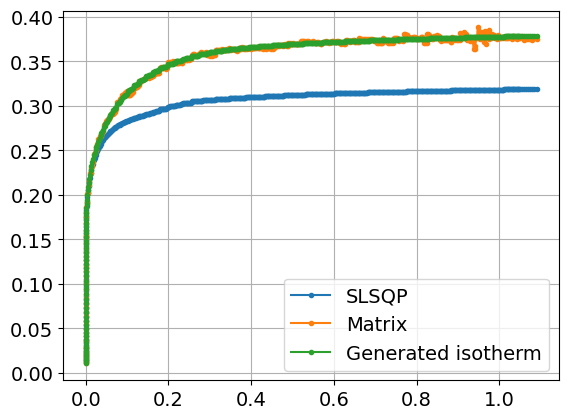

In [11]:
# строим изотермы по полученному распределению пор
gen1 = copy.deepcopy(gen)
gen2 = copy.deepcopy(gen)
gen1.pore_distribution = fit1_noise.x
gen2.pore_distribution = fit2_noise[0]
gen1.calculate_isotherms()
gen2.calculate_isotherms()
plt.plot(gen1.pressures_s, gen1.n_s, marker=".", label="SLSQP")
plt.plot(gen2.pressures_s, gen2.n_s, marker=".", label="Matrix")
plt.plot(gen.pressures_s, gen.n_s, marker=".", label="Generated isotherm")
plot()

### Теперь с экспериментальной изотермой угля

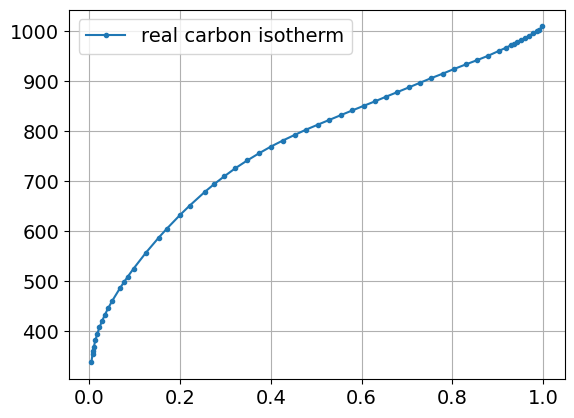

In [12]:
exp_data = np.loadtxt("data/real/carbon.txt")
p_exp = np.empty(len(exp_data))
n_exp = np.empty(len(exp_data))
for i in range(len(exp_data)):  # Загружаем адсорбцию и давления
    p_exp[i] = exp_data[i][0]
    n_exp[i] = exp_data[i][1]
j = np.argmax(n_exp)  # Отделяем адсорбционную ветку
n_s_exp_raw = n_exp[:j]
p_exp_sorb = p_exp[:j]
plt.plot(p_exp_sorb, n_s_exp_raw, marker=".", label="real carbon isotherm")
plot()

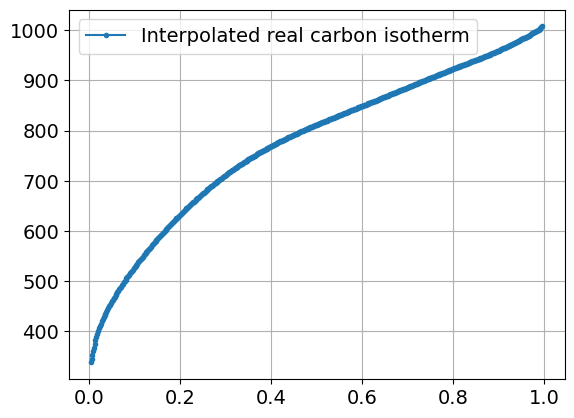

In [13]:
# интерполируем экспериментальную изотерму под давления кернала
n_s_exp_uncut = np.interp(gen.pressures_s, p_exp_sorb, n_s_exp_raw)
min_exp_pressure_i = np.where(n_s_exp_uncut==min(n_s_exp_uncut))[0][-1]  # индекс первого давления в эксп
max_exp_pressure_i = sorted((np.abs(gen.pressures_s - p_exp_sorb[-1])).argsort()[:1], reverse=False)[0]  # индекс последнего давления в эксп
n_s_exp = n_s_exp_uncut[min_exp_pressure_i:max_exp_pressure_i]
pressures_s_cut = gen.pressures_s[min_exp_pressure_i:max_exp_pressure_i]
cut_kernel = (kernel_carbon.T[min_exp_pressure_i:max_exp_pressure_i]).T  # отрезаем от кернела давления которых нет в эксперименте
plt.plot(pressures_s_cut, n_s_exp, marker=".", label="Interpolated real carbon isotherm")
plot()

In [36]:
fit1_exp= fit_SLSQP(adsorption=n_s_exp, kernel=cut_kernel, a_array=pore_widths)

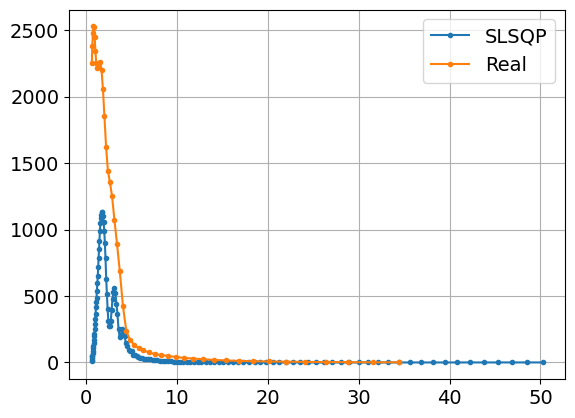

In [37]:
real_distr = np.loadtxt("data/real/carbon_distr.txt", skiprows=4, unpack=True)
plt.plot(pore_widths, fit1_exp.x, marker=".", label="SLSQP")
plt.plot(real_distr[0], real_distr[4], marker=".", label="Real")
#plt.yscale("log")
plot()

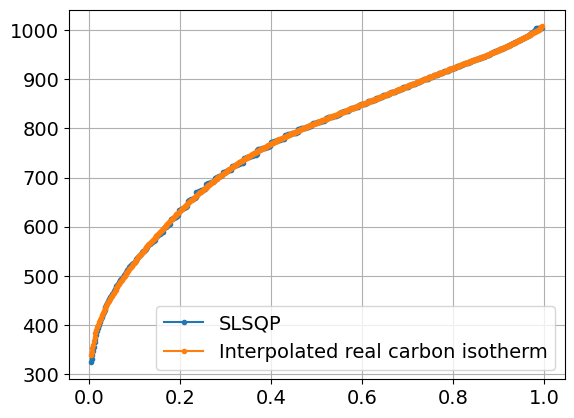

In [16]:
# строим изотермы по полученному распределению пор
gen1_exp = copy.deepcopy(gen)
gen2_exp = copy.deepcopy(gen)
gen1_exp.pore_distribution = fit1_exp.x
gen1_exp.calculate_calculate_isotherms_right()
plt.plot(gen1_exp.pressures_s[min_exp_pressure_i:max_exp_pressure_i], gen1_exp.n_s[min_exp_pressure_i:max_exp_pressure_i], marker=".", label="SLSQP")
plt.plot(pressures_s_cut, n_s_exp, marker=".", label="Interpolated real carbon isotherm")
plot()

### Нейросеть

In [17]:
# импортируем модель
import keras
import tensorflow as tf
model = keras.models.load_model('data/models/carbon2_best.keras', custom_objects={'abs': tf.math.abs})

In [18]:
x_scale = max(n_s_exp)
fit3_exp = model.predict(np.array([(n_s_exp)/x_scale])).T  # получаем ответ от нейросети

# gen3_exp = copy.deepcopy(gen)  # нормируем на реальную изотерму
# gen3_exp.pore_distribution = fit3_exp
# gen3_exp.calculate_isotherms()
# scale_res = max(n_s_exp) / max(gen3_exp.n_s)

1/1 [==============================] - 0s 92ms/step


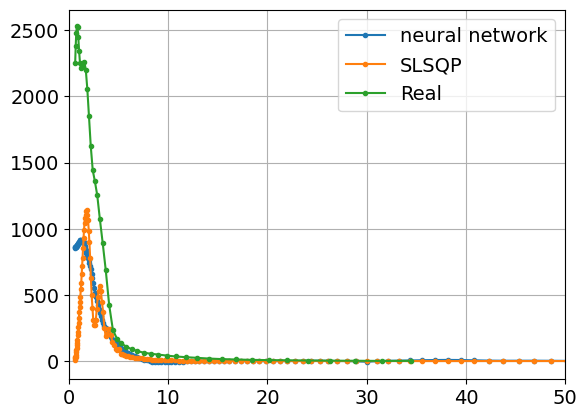

In [19]:
plt.plot(pore_widths, fit3_exp*max(n_s_exp), marker=".", label="neural network")
plt.plot(pore_widths, fit1_exp.x, marker=".", label="SLSQP")
plt.plot(real_distr[0], real_distr[4], marker=".", label="Real")
#plt.yscale("log")
plt.xlim(0, 50)
plot()

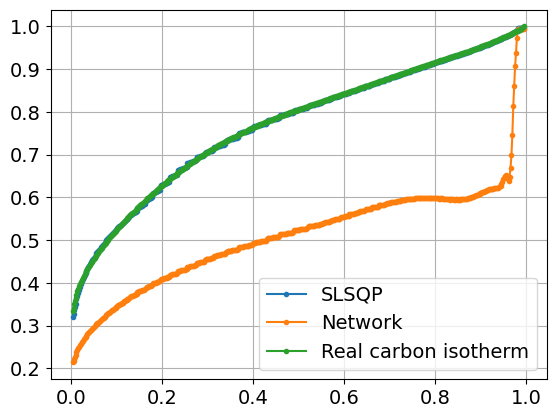

In [20]:
fit3_exp_shaped = fit3_exp.reshape(130,)
# fit3_exp_shaped[-40:] = np.zeros(40)
# print(pore_widths[-40])

gen3_exp = copy.deepcopy(gen)
gen3_exp.pore_distribution = fit3_exp_shaped * x_scale
gen3_exp.calculate_calculate_isotherms_right()
gen1_exp.calculate_calculate_isotherms_right()
plt.plot(gen1_exp.pressures_s[min_exp_pressure_i:max_exp_pressure_i], gen1_exp.n_s[min_exp_pressure_i:max_exp_pressure_i]/np.max(gen1_exp.n_s), marker=".", label="SLSQP")
plt.plot(gen3_exp.pressures_s[min_exp_pressure_i:max_exp_pressure_i], gen3_exp.n_s[min_exp_pressure_i:max_exp_pressure_i]/np.max(gen3_exp.n_s), marker=".", label="Network")
plt.plot(pressures_s_cut, n_s_exp/np.max(n_s_exp), marker=".", label="Real carbon isotherm")
plot()

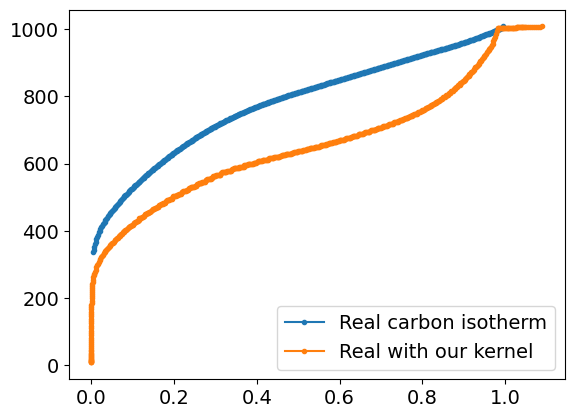

In [23]:
#total_V_exp = np.sum((real_distr[0][1:]-real_distr[0][:-1])*real_distr[4][:-1])
gen4_exp = copy.deepcopy(gen)
interp_real_distr = np.interp(gen4_exp.a_array, real_distr[0], real_distr[4])
#total_V_interp = np.sum((gen4_exp.a_array[1:]-gen4_exp.a_array[:-1])*interp_real_distr[:-1])
gen4_exp.pore_distribution = interp_real_distr
gen4_exp.calculate_calculate_isotherms_right()
interp_scale = np.max(n_s_exp)/np.max(gen4_exp.n_s)
plt.plot(pressures_s_cut, n_s_exp, marker=".", label="Real carbon isotherm")
plt.plot(gen4_exp.pressures_s, gen4_exp.n_s*interp_scale, marker=".", label="Real with our kernel")
plt.legend()
plt.show()